In [17]:
#This program is used for IBM Quantum's public superconducting quantum computers
#Using the calibrated pulses on those quantum computers, this program produces the RXX Gate, a special parametrized quantum gate, in terms of microwave pulses
#Implementation with microwave pulses allows for shorter duration and just as (if not more) accurate gate execution

import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.pulse.library import Gaussian
from qiskit import pulse as qiskit_pulse                  # This is where we access all of our Pulse features!
from qiskit.pulse import transforms
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
account_provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_name = 'ibm_perth'
backend = provider.get_backend(backend_name)

#This captures the pulse calibrations for a particular backend
defaults = backend.defaults()
calibrations = defaults.instruction_schedule_map
config = backend.configuration()

ibmqfactory.load_account:WARNING:2023-10-14 17:44:48,051: Credentials are already in use. The existing account in the session will be replaced.


In [18]:
#Functions defined to create template pulses for gates necessary to construct RXX gate

def S_Gate(qubit):
    #Produces the Pulse object to execute S gate (Half-Z Gate)
    #Since Z gate can be achieved with a frame shift, this pulse solely consists of a frame shift of pi/2
    
    with qiskit_pulse.build(backend, name="S Gate") as S_Gate:
        qiskit_pulse.shift_phase(-1*np.pi/2, qiskit_pulse.DriveChannel(qubit))
        
    S_Gate = transforms.block_to_schedule(S_Gate)
    
    return S_Gate


def SX_Gate(qubit):
    #Retrieves pulse for Half-X Gate
    #Already calibrated on backend
    
    SX_Gate = calibrations.get('sx', [qubit])
    
    return SX_Gate


def H_Gate(qubit):
    #Combines Half-X and Half-Z gates to create single Pulse object to replicate H-gate
    
    H_Gate = qiskit_pulse.Schedule()
    H_Gate += S_Gate(qubit)
    H_Gate += SX_Gate(qubit)
    H_Gate += S_Gate(qubit)
    
    return H_Gate

def CX_Gate(control_qubit, target_qubit):
    #Retrieves calibrated pulse for CX Gate
    #Used to extract Echoed Cross Resonance Pulses
    
    CX_Gate = calibrations.get('cx', [control_qubit, target_qubit])
    
    return CX_Gate

def X_Gate(qubit):
    #Retrieves calibrated pulse for X-Gate    
    
    X_Gate = calibrations.get('x', [qubit])
    
    return X_Gate

      
def identify_indices(cx_pulse):
    #Given a calibrated a pulse for a CX-Gate
    #Function identifies which elements of the pulse sequence are the Echoed Cross Resonance pulses
    #ECR pulse consists of four CR pulses: CR(theta) on the drive channel, CR(-1 * theta) on the drive channel, CR(theta) on the control channel, and CR(-1 * theta) on the control channel
    #Each is abbreviated as CRPD (CR Positive Drive), CRMD (CR Minus Drive), CRPU (CR Positive Control), and CRMU (CR Negative Control).
    #Qiskit convention is to refer to the control channel with 'u'
    
    children = cx_pulse.children
    indices = {}
    
    for a in range(len(children)):

        child = children[a]
        string = str(child[1]).lower()
        text = string.split('cr90')

        if len(text) == 3:

            if 'gaussiansquare' in text[0]:

                characters = text[1][0:3]

            else:
                continue

        else:
            continue

        if characters[0] == 'p':

            if characters[2] == 'd':
                indices['crpd'] = a
                #indices['crpu'] = a

            elif characters[2] == 'u':
                indices['crpu'] = a

        elif characters[0] == 'm':

            if characters[2] == 'd':
                indices['crmd'] = a
                
            elif characters[2] == 'u':
                indices['crmu'] = a

    return indices  
    

def extract_pulse_values(instruction):
    #Given a CR Pulse
    #This function returns its parameters in a GaussianSquare Pulse object (as defined in Qiskit)
    
    string = str(instruction).lower()          
    pulse_values = string.split('=')
    
    if pulse_values[5].split(',')[0][-1] == ')':
        angle = float(pulse_values[5].split(',')[0][:-1])
    else:    
        angle = float(pulse_values[5].split(',')[0])        
            
    duration = int(pulse_values[1].split(',')[0])
    sigma = float(pulse_values[2].split(',')[0])
    width = float(pulse_values[3].split(',')[0])
    amp = float(pulse_values[4].split(',')[0])
    
    vals = [duration, sigma, width, amp, angle]
    
    return vals

def scale_pulse(pulse, theta):
    #Given a CR Pulse and a theta value
    #This function scales a CR Pulse to parametrize it
    #Allows to parametrize RXX rotation in pulses
    #Process is extracted from Appendix D of https://arxiv.org/abs/2012.11660
    
    samples = 16
    vals = extract_pulse_values(pulse)
    duration, sigma, width, amp, angle = vals[0], vals[1], vals[2], vals[3], vals[4]
    risefall = (duration-width)/2
    num_of_sigmas = 2*risefall/sigma   
    
    area = amp * (width + sigma*np.sqrt(2*np.pi)*math.erf(num_of_sigmas))
    gaussian_area = amp*sigma*np.sqrt(2*np.pi)*math.erf(num_of_sigmas)
    target_area = area * theta/(np.pi/2) 
    
    
    if target_area >= area:
        
        new_width = ((target_area - area) + width * amp)/amp
        new_amplitude = amp    
        new_duration = (new_width + num_of_sigmas * sigma)/samples
        new_duration = math.ceil(new_duration) * samples
    
    elif area > target_area > gaussian_area:
        
        new_width = (target_area - gaussian_area)/amp        
        new_amplitude = amp        
        new_duration = (new_width + num_of_sigmas * sigma)/samples
        new_duration = math.ceil(new_duration) * samples
    
    elif target_area <= gaussian_area:
        
        new_width = 0        
        new_amplitude = target_area/(gaussian_area/amp)        
        new_duration = (new_width + num_of_sigmas * sigma)/samples
        new_duration = math.ceil(new_duration) * samples        
        
    return qiskit_pulse.GaussianSquare(duration = int(new_duration), sigma= sigma, width= new_width, amp= new_amplitude , angle=angle )
    
def Echoed_Cross_Resonance(qubit1, qubit2, theta):
    #This function returns a pulse schedule for an Echoed Cross Resonance gate given a theta value on two qubits (for which the necessary gates have been calibrated)    
    
    CX_Pulse = CX_Gate(qubit1, qubit2)
    X_Pulse = X_Gate(qubit1)
    
    indices = identify_indices(CX_Pulse)
        
    CR_Plus_D = qiskit_pulse.Schedule()
    
    #Extracts CRPD pulse from calibrated CX-Gate pulse sequence, scales it for given theta, then applies it on appropriate drive channel
    CR_Plus_D += qiskit_pulse.Play(scale_pulse(CX_Pulse.children[indices.get('crpd')][1], theta), qiskit_pulse.DriveChannel(qubit2))

    CR_Plus_U = qiskit_pulse.Schedule()
    CR_Plus_U += qiskit_pulse.Play(scale_pulse(CX_Pulse.children[indices.get('crpu')][1], theta), qiskit_pulse.ControlChannel(qubit1))

    CR_Minus_D = qiskit_pulse.Schedule()
    CR_Minus_D += qiskit_pulse.Play(scale_pulse(CX_Pulse.children[indices.get('crmd')][1], theta), qiskit_pulse.DriveChannel(qubit2))

    CR_Minus_U = qiskit_pulse.Schedule()
    CR_Minus_U += qiskit_pulse.Play(scale_pulse(CX_Pulse.children[indices.get('crmu')][1], theta), qiskit_pulse.ControlChannel(qubit1))
            
    CR_PD_Duration = CR_Plus_D.duration
    X_Pulse_Duration = X_Pulse.duration
    
    ECR = qiskit_pulse.Schedule()
      
    #Constructs ECR pulse with its components into one single pulse schedule
    
    ECR += CR_Plus_D
    ECR += CR_Plus_U
        
    ECR += qiskit_pulse.Delay(CR_PD_Duration, qiskit_pulse.DriveChannel(qubit1))
    
    ECR += X_Pulse
       
    ECR += qiskit_pulse.Delay(CR_PD_Duration, qiskit_pulse.DriveChannel(qubit1))

    ECR += qiskit_pulse.Delay(X_Pulse_Duration, qiskit_pulse.DriveChannel(qubit2))
    ECR += qiskit_pulse.Delay(X_Pulse_Duration, qiskit_pulse.ControlChannel(qubit1))
    
    
    ECR += CR_Minus_D
    ECR += CR_Minus_U
    
    ECR += X_Pulse
            
    return ECR


def RXX_Gate(qubit1, qubit2, theta):
    #Function combines H-Gate and ECR-Gate pulse schedules
    #Returns complete pulse schedule for paramaterized RXX Rotation
    
    RXX_Gate = qiskit_pulse.Schedule()
    RXX_Gate += H_Gate(qubit1)    
    RXX_Gate += Echoed_Cross_Resonance(qubit1, qubit2, theta)    
    RXX_Gate += H_Gate(qubit1)
    
    return RXX_Gate

In [19]:
theta_values = np.linspace(0, np.pi, 100)

Pulse_Circuits = []

for val in theta_values:

    qc = QuantumCircuit(2,2)

    rxx = Gate('RXX', 2, [])

    qc.append(rxx, [0,1])

    qc.add_calibration('RXX', [0,1], RXX_Gate(0,1,val))

    qc.measure(range(2), range(2))

    Pulse_Circuits.append(qc)
    
#pulse_job = execute(Pulse_Circuits, backend, shots=10000) #UNCOMMENT TO EXECUTE CIRCUITS
#pulse_job_id = pulse_job.job_id()
#Runs 100 RXX rotations in pulses for 100 theta values from 0 to pi 

In [20]:
theta_values = np.linspace(0, np.pi, 100)

Qiskit_Circuits = []

for val in theta_values:
    qc = QuantumCircuit(2,2)
    
    qc.rxx(val, 0, 1)
    
    qc.measure(range(2), range(2))
    
    Qiskit_Circuits.append(qc)
    
#job = execute(Qiskit_Circuits, backend, shots=10000) #UNCOMMENT TO EXECUTE CIRCUITS
#qiskit_job_id = qiskit_job.job_id()
#Runs 100 RXX rotations with Qiskit's transpiler at the gate-level for 100 theta values from 0 to pi

In [ ]:
num_of_shots = 10000 #number of shots used to run Pulse-Implementation and Qiskit-Implementation of RXX Gates

qiskit_job = service.job(qiskit_job_id)
pulse_job = service.job(pulse_job_id)

theta_values = np.linspace(0, np.pi, 200)

qiskit_zero_states = []
    
for a in range(len(qiskit_transpiler_job.result().get_counts())):
    
    #Retrives the counts of the '00' state with the Qiskit-Implementation of RXX gate
    #Additional code is included within for loop to account for the counts of other states, if needed
    
    dicts = qiskit_transpiler_job.result().get_counts()
    
    first = dicts[a].get('00')
    second = dicts[a].get('01')
    third = dicts[a].get('10')
    fourth = dicts[a].get('11')
    
    
    if '00' not in qiskit_transpiler_job.result().get_counts()[a].keys():
        first = 0
        
    if '01' not in qiskit_transpiler_job.result().get_counts()[a].keys():
        second = 0
        
    if '10' not in qiskit_transpiler_job.result().get_counts()[a].keys():
        third = 0
        
    if '11' not in qiskit_transpiler_job.result().get_counts()[a].keys():
        fourth = 0
    
    qiskit_zero_states.append(first)
    

pulse_zero_states = []


for a in range(len(pulse_job.result().get_counts())):
    
    #Retrives the counts of the '00' state with the Pulse-Implementation of RXX gate
    #Additional code is included within for loop to account for the counts of other states, if needed
    
    dicts = pulse_job.result().get_counts()
    
    first = dicts[a].get('00')
    second = dicts[a].get('01')
    third = dicts[a].get('10')
    fourth = dicts[a].get('11')
    
    if '00' not in pulse_job.result().get_counts()[a].keys():
        first = 0
        
    if '01' not in pulse_job.result().get_counts()[a].keys():
        second = 0
        
    if '10' not in pulse_job.result().get_counts()[a].keys():
        third = 0
        
    if '11' not in pulse_job.result().get_counts()[a].keys():
        fourth = 0
    
    
    pulse_zero_state.appends(first)

#Counts of '00' states are plotted in comparison to expected counts to observe accuracy of each implementation

x = np.linspace(0, np.pi, 100)

y1 = transpiler_zero_state
y2 = pulse_zero_state
y3 = [num_of_shots*(np.cos(a/2)**2)  for a in x] #Mathematically calculated probability of '00' state in terms of theta after RXX gate applied on '00' state

fig, ax = plt.subplots()

transpiler = plt.plot(x,y1)
pulse = plt.plot(x,y2)
theoretical = plt.plot(x, y3)
plt.legend(['Qiskit', 'Pulse', 'Exact'])
plt.show()

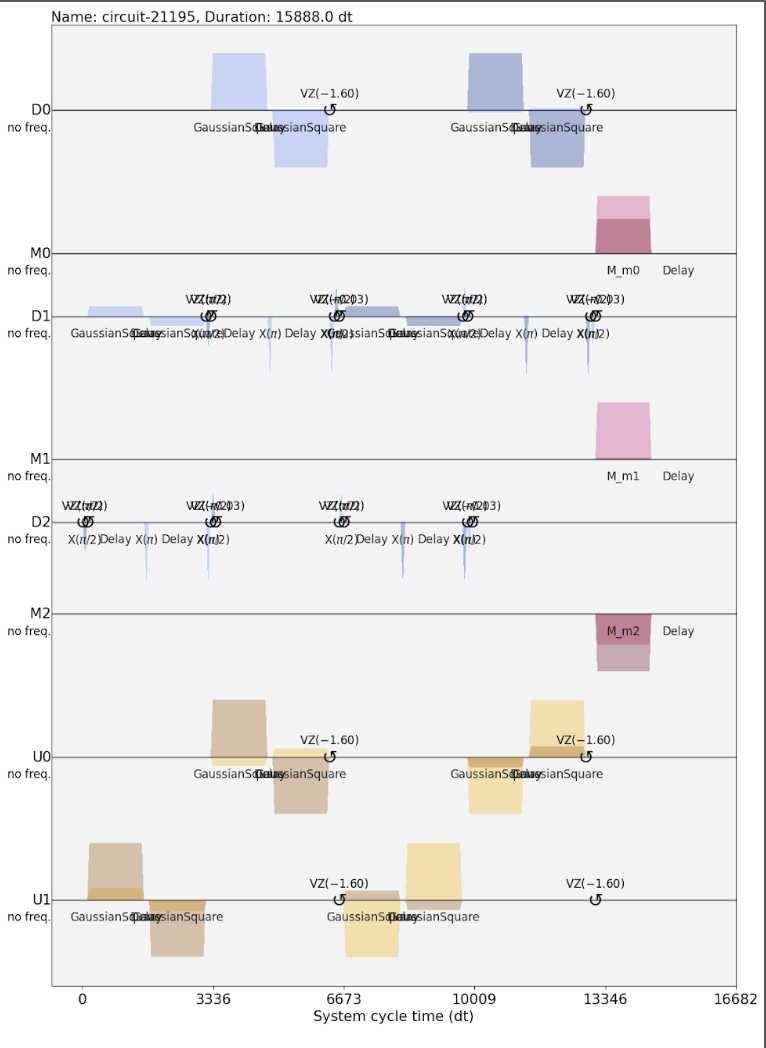

In [3]:
from PIL import Image
from IPython.display import display
img = Image.open('ecrpulse.png')
display(img)

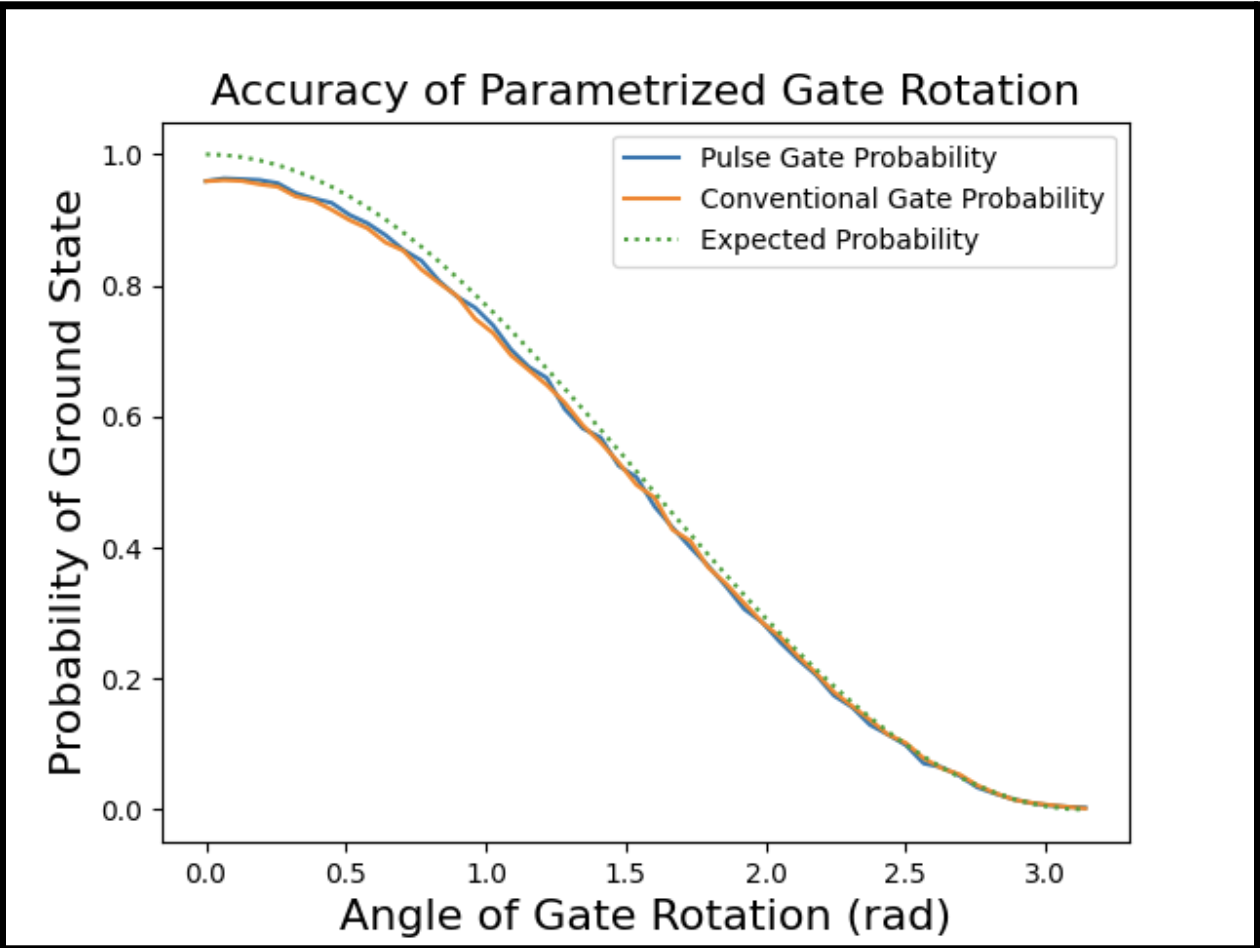

In [4]:
from PIL import Image
from IPython.display import display
img = Image.open('accuracygraph.png')
display(img)

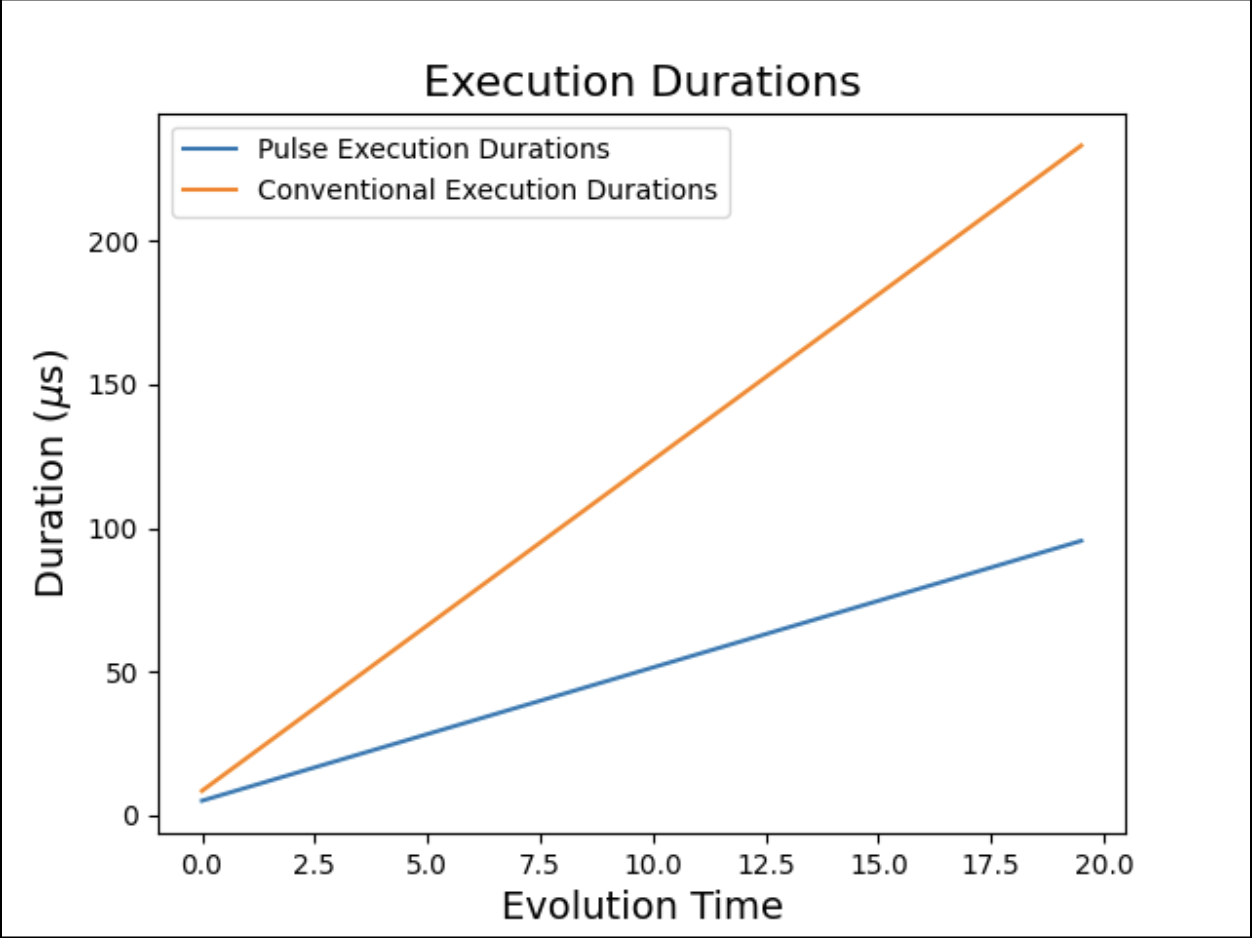

In [5]:
from PIL import Image
from IPython.display import display
img = Image.open('ExecutionDuration.png')
display(img)

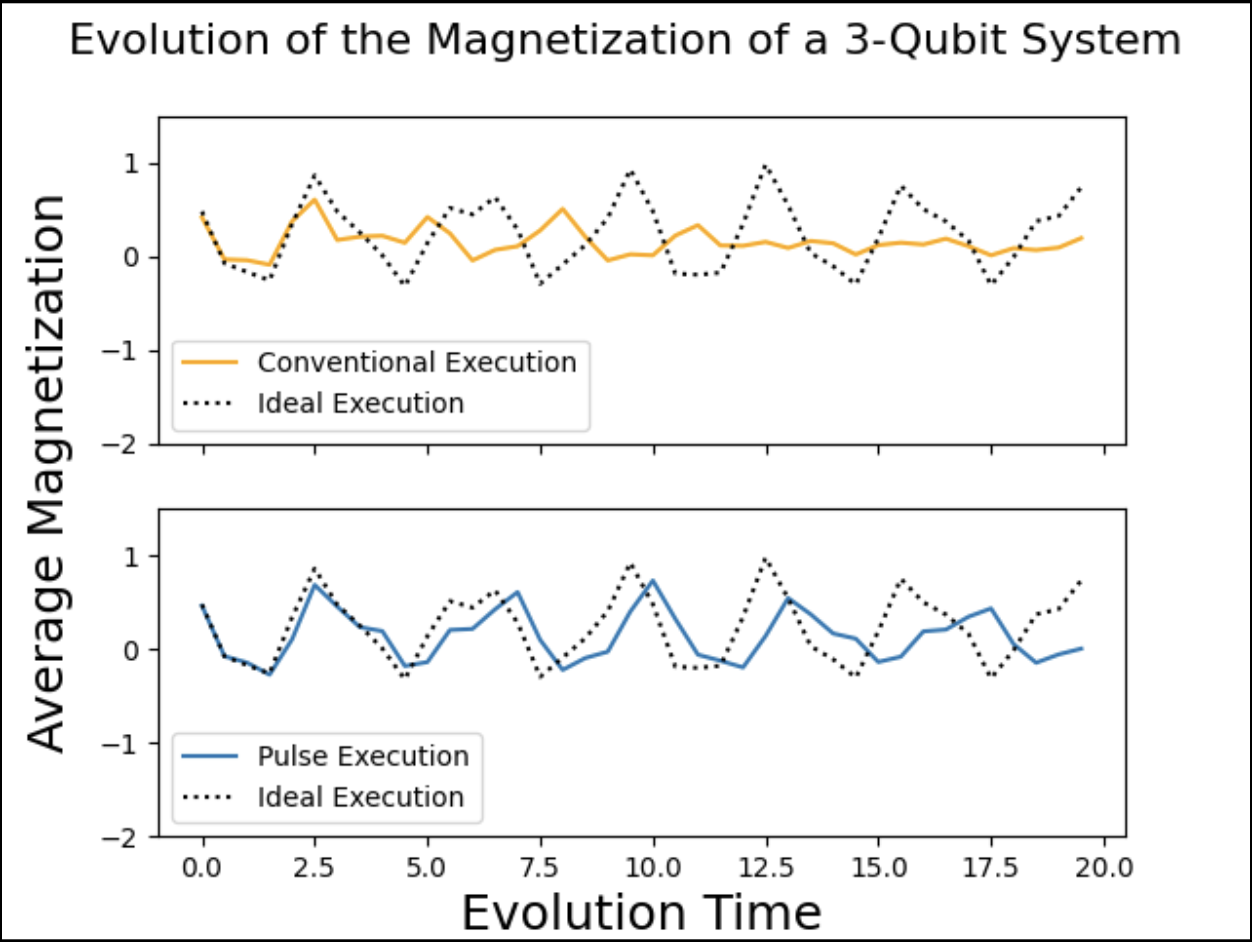

In [6]:
from PIL import Image
from IPython.display import display
img = Image.open('Evolution.png')
display(img)